In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset,random_split
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts,PolynomialLR
from torchvision import transforms, models 
from Data_loader import CustomDataset
from Model import Mobile_Net
import warnings
warnings.filterwarnings("ignore") 
from Chekpoint import Checkpoint
from torchvision import models
from torchsummary import summary   
import cv2    

c:\Users\Ali\Desktop\DIG\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
chk = Checkpoint() 

In [6]:
train_dataset_path = r'C:\Users\Ali\Desktop\DIG\augmnet_v2'  
valid_dataset_path = r'C:\Users\Ali\Desktop\DIG\Noisee_denoise\labels\crop_light_noise_labeling_test'  

transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])



In [7]:
valid_custom_dataset = CustomDataset(root=valid_dataset_path, transform=transform)   
valid_loader = torch.utils.data.DataLoader(valid_custom_dataset, batch_size=64, shuffle=True)
data,label = next(iter(valid_loader))
#show_images(data, label)  


In [8]:
train_custom_dataset = CustomDataset(root=train_dataset_path, transform=transform)   
train_loader = torch.utils.data.DataLoader(train_custom_dataset, batch_size=64, shuffle=True) 
data,label = next(iter(train_loader))   
def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(images.size(0)):
        plt.subplot(1, 10, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Display the batch of images
#show_images(data, label) 


ValueError: num must be an integer with 1 <= num <= 10, not 11

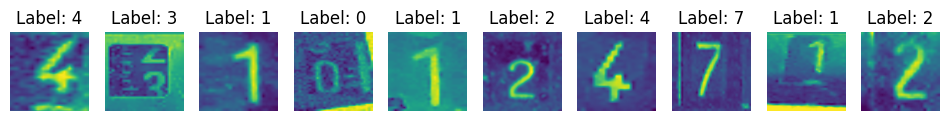

In [9]:
def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(images.size(0)):
        plt.subplot(1, 10, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Display the batch of images
show_images(data, label)                            

In [10]:
def fit(clf,
        train_loader,
        optimizer,
        criterian,
        scheduler):

    clf.train()
    training_loss_running = 0
    training_correct_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(train_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        optimizer.zero_grad()
        out = clf(data)            
        loss = criterian(out, label)                
        training_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        training_correct_running += (pred == label).sum().item()
        loss.backward()
        optimizer.step()
    scheduler.step() 
    train_loss = training_loss_running / counter
    train_accuracy = 100. * training_correct_running / total
    print(optimizer.param_groups[0]['lr'])
    return train_loss, train_accuracy     



In [11]:
def validation (clf,validation_loader,criterian,epoch):
    clf.eval()
    valid_loss_running = 0
    valid_acc_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(validation_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        out = clf(data)
        loss = criterian(out, label)
        valid_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        valid_acc_running += (pred == label).sum().item()

    valid_loss = valid_loss_running / counter
    valid_acc = 100. * valid_acc_running / total  
    chk.save(valid_acc,'chk',epoch,clf)
      

    return valid_loss,valid_acc
       


In [12]:
def train (hyparam,train_loader,val_loader):

    clf = Mobile_Net()
    #optimizer = torch.optim.Adam(clf.parameters(), lr =hyparam['lr'])
    optimizer = torch.optim.Adam(clf.parameters(), lr=hyparam['lr'])
    criterian = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1)
    #scheduler = PolynomialLR(optimizer,  total_iters=5, power=1)
    train_loss =[]
    train_acc =[]
    val_loss =[]
    val_acc = []
    
    for epoch in range(hyparam['epoch']):
        print(f"Epoch {epoch+1} of {hyparam['epoch']}")
        training_loss,training_acc = fit(clf,train_loader,optimizer,criterian,scheduler)
        validation_loss,validation_acc = validation(clf,val_loader,criterian,epoch)

        train_loss.append(training_loss)
        train_acc.append(training_acc)

        val_loss.append(validation_loss)
        val_acc.append(validation_acc)

        

       
        
    
        print(f"Train Loss: {training_loss:.4f}, Train Acc: {training_acc:.2f},\
         Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.2f}")



      
    return clf,train_loss,train_acc,val_loss,val_acc
        



In [1]:
hparams = {'batch_size': 256, 'lr': 0.4e-4, 'epoch': 32} #6e-4      
clf,train_loss,train_acc,val_loss,val_acc = train(hparams,train_loader,valid_loader)   

NameError: name 'train' is not defined

In [40]:
img_path = r'C:\Users\Ali\Desktop\DIG\dd\Bri_sharp_org\00\augmented_71_brightness_0.2952248454093933.png'
#img_path = r'C:\Users\Ali\Desktop\DIG\fc30fca7.png'
img1 = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
img = transform(img1) 
out = clf(img.unsqueeze(0))
_,pred = torch.max(out.data,1)
pred     

tensor([0])